# Implicit attention

The attention mechanism is very intuitive, and its definition could be generally speaking ''ignoring unnecessary information'', or ''attending to necessary information''.
This is correct that we as human beings do that too: when we talk to someone we attend to what he/she says and not to other noises around us. (we will get back to this example!)

Any machine learning task to be successful needs attention to important/informative inputs; machine learning models require to pick up this attention somehow to deliver a good performance, and actually we may say if a machine learning model is working well it means that it somehow figured out how to learn to attend to necessary information. This is called *implicit attention*, which means the model learns to attend properly without ''explicitly'' designing any attention setup.

Let's take a simple linear regression model into account:

$$ Y = W^T X + b$$
what does this model do? it simply assigns some weights to different input attributes and sum them up (and maybe later apply a function like softmax to convert it to a probability). Let's take an example where there is a lot of attribute but only some of them are informative.

Let's use the MNIST dataset




## Getting MNIST data

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
class MNIST:
    def __init__(self, root:str='./data/mnist'):
        if not os.path.isdir(root):
            os.makedirs(root)
        transform = transforms.Compose([transforms.ToTensor()])
        self.train_set = dataset.MNIST(root=root, train=True, transform=transform, download=True)
        self.test_set = dataset.MNIST(root=root, train=False, transform=transform, download=True)

    def subset_traindata(self, labels:list):
        targets = self.train_set.targets
        indeces = [i for i in range(len(targets)) if targets[i] in labels]
        train_subset = torch.utils.data.Subset(self.train_set, indeces)
        return train_subset

In [76]:
from src.data_builder import mnist
mnist_data = mnist.MNIST()


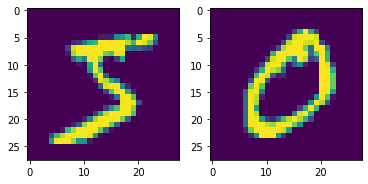

In [6]:
from src.visualization.plotting import image_plotting
image_plotting([mnist_data.train_set.data[0],mnist_data.train_set.data[1]])

To recognize the digit, we need to only attend to some of the pixels, many of the pixels around the images are zero and have no value.

Thus if we train a linear logistic regression and the model does a good job in recognizing the digits, it must have figured out to attend to the informative pixels in the center of the image.

*Let's try it then*

In [18]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

## Setting up the experiment data

For the sake of demonstration we only take 2 classes of the digits

In [77]:
batch_size=64
subset_data = mnist_data.subset_traindata(labels=[7,9])
train_loader = DataLoader(subset_data, batch_size=batch_size, shuffle=True)

In [124]:
class LinearClassifier(nn.Module):
    def __init__(self, dim, num_output):
        super(LinearClassifier,self).__init__()
        self.linear_model = nn.Linear(dim*dim, num_output, bias=True, dtype=torch.float64)
        
    def forward(self, x):
        logits = self.linear_model(x.to(torch.float64))
        return output

lm = LinearClassifier(dim=28, num_output=2)
optimizer = optim.Adagrad(lm.parameters(), lr=0.01, weight_decay=1e-1)
criterion = torch.nn.CrossEntropyLoss()

In [125]:
class Trainer:
    def __init__(self, model, optimizer, criterion, train_data, num_epoch):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.data = train_data
        self.num_epoch = num_epoch
        self.train_loss=[]
        self.val_loss=[]

    def run(self, verbose=0):
        batch_size = self.data.batch_size
        for epoch in range(0,self.num_epoch):
            for batch_id, (x, y) in enumerate(self.data):
                x = x.flatten(start_dim=1)
                y_pred = self.model(x)
                loss = self.criterion(y_pred, y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.train_loss.append(loss.item())
            if verbose>0: print(f"epoch {epoch} is ended: train loss {torch.mean(torch.Tensor(self.train_loss))}")



In [126]:
trainer = Trainer(model=lm, optimizer=optimizer,
                  criterion=criterion, train_data=train_loader, num_epoch = 1000)
trainer.run(verbose=1)

ValueError: Expected input batch_size (11379) to match target batch_size (64).

In [118]:
train_set = mnist_data.train_set
small_train_x

tensor([], size=(0, 28, 28), dtype=torch.float64)

In [119]:
# lets take 2 classes
class1_label = 2
class2_label = 5
# index the labels with integers:
small_dataset_idx = (train_set.targets == class1_label) | (train_set.targets == class2_label)
small_train_x = train_set.data[small_dataset_idx].to(torch.float64)
small_train_y = train_set.targets[small_dataset_idx].long()
small_train_y[small_train_y==class1_label]=0
small_train_y[small_train_y==class2_label]=1

num_samples, dim, _ = small_train_x.shape
output_size = small_train_y.unique().size()

for the logistic regression model we need to convert the image into a vector:

In [120]:
# vectorizing the images
small_train_x_vector = torch.reshape(small_train_x,(num_samples, dim*dim))

## Modeling logistic regression

We use torch APIs to train the model:

In [121]:
# lets fit a linear model
LinearTransform = torch.nn.Linear(dim*dim, 2, bias=True, dtype=torch.float64)
output = torch.log_softmax(LinearTransform(small_train_x_vector), dim=1)

In [122]:
small_train_x_vector

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [123]:
num_epoch=1000
train_losses=[]
for i in range(num_epoch):
    y_pred = torch.sigmoid(LinearTransform(small_train_x_vector))
    loss = criterion(y_pred, small_train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
loss

tensor(0.6545, dtype=torch.float64, grad_fn=<NllLossBackward0>)

As we discussed above, the weights in a linear regression model reflects how the model attends to the input features implicitly. So let's visualize the weights:

**NOTE**: in this model we have two classes and two output nodes, and therefore we have two sets of weights each maps the pixels to one of the output nodes.

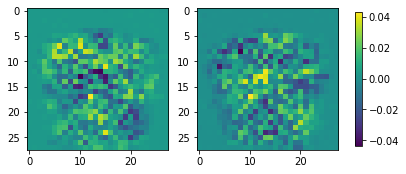

In [21]:
weights = list(LinearTransform.parameters())[0]
fig, ax = plt.subplots(1,2)
for output in range(0,2):
    im = ax[output].imshow(torch.reshape(weights.data[output],(dim,dim)))
_ = fig.colorbar(im,ax=ax.ravel().tolist(), fraction=0.02)

The plots above show that the weights are learned to extract information mainly from the center of the images, and the learned weights for the pixels off the center are almost equal (and close to zero).

This is an example of implicit attention: we have not made any extra design in the model, and the model learns to attend well to deliver a good performance.
Here the model is simple, but the task also is not very difficult; if the task is more difficult, we need to use a more complicated model to get a reasonable performance. 

## Modeling a CNN

Let's stick with the MNIST data set, but take the whole 10 classes. This is still not a very difficult task, but we may need a more complex model to get a good performance. A simple CNN model works pretty good for MNIST. Here we make a CNN model:  

In [22]:
num_classes= 10
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

In [23]:
class NNet(nn.Module):
    def __init__(self, n_classes):
        super(NNet, self).__init__()
        self.feature_extractor = nn.Sequential(
        nn.Conv2d(1,10,kernel_size=5),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(),
        nn.Conv2d(10,20, kernel_size=5),
        nn.Dropout2d(),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU()
        )
        
        self.classifier=nn.Sequential(
        nn.Linear(320,50),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(50,n_classes)
        )
        
    
    def forward(self,x):
        x = self.feature_extractor(x)
        x = torch.flatten(x,1)
        logits = self.classifier(x)
        probs = F.log_softmax(logits,dim=1)
        return probs

In [24]:
network = NNet(num_classes)
optimizer = optim.Adagrad(network.parameters(), lr=0.1, weight_decay=1e-10)
criterion = torch.nn.CrossEntropyLoss()


In [25]:
network.train()
loss_track=[]
num_epoch=5

for epoch in range(0,num_epoch):
    for batch_id, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = network(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        loss_track.append(loss.detach().numpy())   
        if batch_id % 500 == 0:
            print(f'epoch {epoch+1}: loss = {loss}')   

epoch 1: loss = 2.326418161392212
epoch 1: loss = 0.6355805993080139
epoch 2: loss = 0.27389445900917053
epoch 2: loss = 0.32802799344062805
epoch 3: loss = 0.21118666231632233
epoch 3: loss = 0.22996285557746887
epoch 4: loss = 0.5050382018089294
epoch 4: loss = 0.3011983335018158
epoch 5: loss = 0.3362125754356384
epoch 5: loss = 0.22282220423221588


For the logistic regression model, we directly looked into the weights to investigate how well the model attends to the right inputs. How should we check the model's attention for more complex models like the CNN we trained above?

The answer is by calculating the Jacobian matrix. For each output input pair ($x_i, y_j$), the *ij*th element of the Jacobian matrix is:

$$
\frac{\partial y_j}{\partial x_i}
$$

if the model has been trained to attend to $x_i$ as an important feature to predict $y_j$, the corresponding derivative should be high.

For the simple logistic regression model, we see that the weights $W$ equate to the Jacobian matrix.

Thanks to Pytorch, calculating the Jacobian matrix is pretty straightforward. 

In [26]:
ind=1 ## choosing an input image (arbitrarily)
Jacobian_mat = torch.autograd.functional.jacobian(network, X[[ind]]).view(10,28,28)

Let's visualize the Jacobian matrix elements:

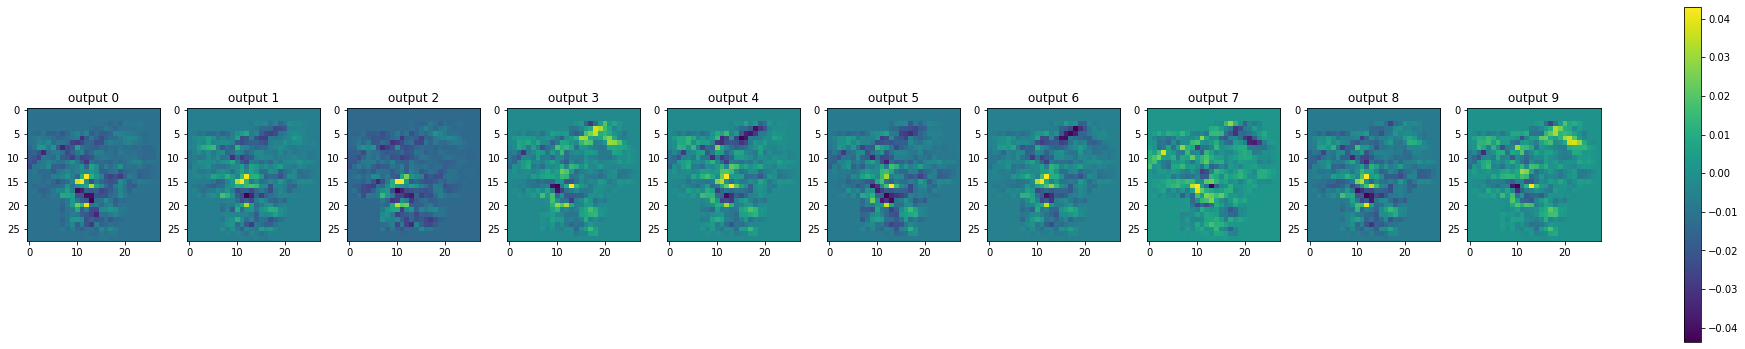

In [27]:
fig, ax = plt.subplots(1,num_classes, figsize=(30,30))
for i in range(num_classes):
    ax[i].imshow(Jacobian_mat[i])
    ax[i].set_title(f'output {i}')
_ = plt.colorbar(im,ax=ax.ravel().tolist(), fraction=0.01)

Again we can see that the main attention is on the center of the images. Note that unlike the logistic regression model the attention pattern varies by input (change the "ind" variable and check it out), because the model is more complex and potentially can perform better through a more subtle implicit attention.